Climate Resilience Project Portfolio: Southern Africa

A Data-Driven Analysis with Python

1. Project Overview & Objectives

This project analyzes climate patterns in Southern Africa to:

*   Identify historical climate trends and futureprojections
*   Assess vulnerability across different regions
*   Develop targeted mitigation and adaptation strategies
*   Provide actionable insights for policymakers

In [9]:

# 1. Data Analysis & Strategy Development

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

# List Southern Africa countries
southern_africa_countries = [
    'South Africa', 'Namibia', 'Botswana', 'Zimbabwe', 'Mozambique',
    'Zambia', 'Malawi', 'Angola', 'Lesotho', 'Eswatini'
]

print("Target Countries for Analysis:")
for i, country in enumerate(southern_africa_countries, 1):
    print(f"{i}. {country}")

Target Countries for Analysis:
1. South Africa
2. Namibia
3. Botswana
4. Zimbabwe
5. Mozambique
6. Zambia
7. Malawi
8. Angola
9. Lesotho
10. Eswatini


Data Collection and processing

In [10]:

# 2. Generate synthetic climate data
def generate_synthetic_climate_data(years=30):
    """Generate realistic synthetic climate data for Southern Africa"""
    np.random.seed(42)

    # Create date range
    dates = pd.date_range(start='1990-01-01', end='2020-12-31', freq='M')

    # Country characteristics
    country_profiles = {
        'South Africa': {'temp_base': 18, 'precip_base': 500, 'temp_trend': 0.03, 'arid': True},
        'Namibia': {'temp_base': 22, 'precip_base': 250, 'temp_trend': 0.035, 'arid': True},
        'Botswana': {'temp_base': 23, 'precip_base': 400, 'temp_trend': 0.032, 'arid': True},
        'Zimbabwe': {'temp_base': 21, 'precip_base': 650, 'temp_trend': 0.028, 'arid': False},
        'Mozambique': {'temp_base': 25, 'precip_base': 900, 'temp_trend': 0.025, 'arid': False},
        'Zambia': {'temp_base': 22, 'precip_base': 1000, 'temp_trend': 0.026, 'arid': False},
        'Malawi': {'temp_base': 23, 'precip_base': 900, 'temp_trend': 0.027, 'arid': False},
        'Angola': {'temp_base': 24, 'precip_base': 800, 'temp_trend': 0.029, 'arid': False},
        'Lesotho': {'temp_base': 12, 'precip_base': 700, 'temp_trend': 0.031, 'arid': False},
        'Eswatini': {'temp_base': 20, 'precip_base': 750, 'temp_trend': 0.030, 'arid': False}
    }

    data = []
    for country in southern_africa_countries:
        profile = country_profiles[country]

        for date in dates:
            year_factor = (date.year - 1990) * profile['temp_trend']

            # Temperature with warming trend and seasonality
            base_temp = profile['temp_base'] + year_factor
            seasonal_var = 8 * np.sin(2 * np.pi * date.month/12 + np.pi/6)
            temperature = base_temp + seasonal_var + np.random.normal(0, 1.5)

            # Precipitation with more variability in arid countries
            base_precip = profile['precip_base'] / 12
            if profile['arid']:
                # More erratic rainfall in arid regions
                precip_multiplier = np.random.gamma(1, 2) if np.random.random() > 0.7 else 0.1
            else:
                precip_multiplier = np.random.gamma(2, 1)

            precipitation = max(0, base_precip * precip_multiplier + np.random.normal(0, 10))

            # Drought index (SPEI-like)
            drought_index = np.random.normal(0, 1) - year_factor * 0.1

            data.append({
                'country': country,
                'year': date.year,
                'month': date.month,
                'temperature': temperature,
                'precipitation': precipitation,
                'drought_index': drought_index
            })

    return pd.DataFrame(data)

# Generate and display the data
climate_df = generate_synthetic_climate_data()
print("Synthetic Climate Data Sample:")
print(climate_df.head())
print(f"\nDataset shape: {climate_df.shape}")

# Annual aggregates for trend analysis
annual_data = climate_df.groupby(['country', 'year']).agg({
    'temperature': 'mean',
    'precipitation': 'sum',
    'drought_index': 'mean'
}).reset_index()


Synthetic Climate Data Sample:
        country  year  month  temperature  precipitation  drought_index
0  South Africa  1990      1    25.673274      74.695903      -0.234153
1  South Africa  1990      2    25.648795       6.957080       1.010515
2  South Africa  1990      3    24.056886       0.000000       0.241962
3  South Africa  1990      4    19.130080      12.331117      -1.523876
4  South Africa  1990      5    17.357931       0.000000       1.465649

Dataset shape: (3720, 6)


3. Exploratory Data Analysis

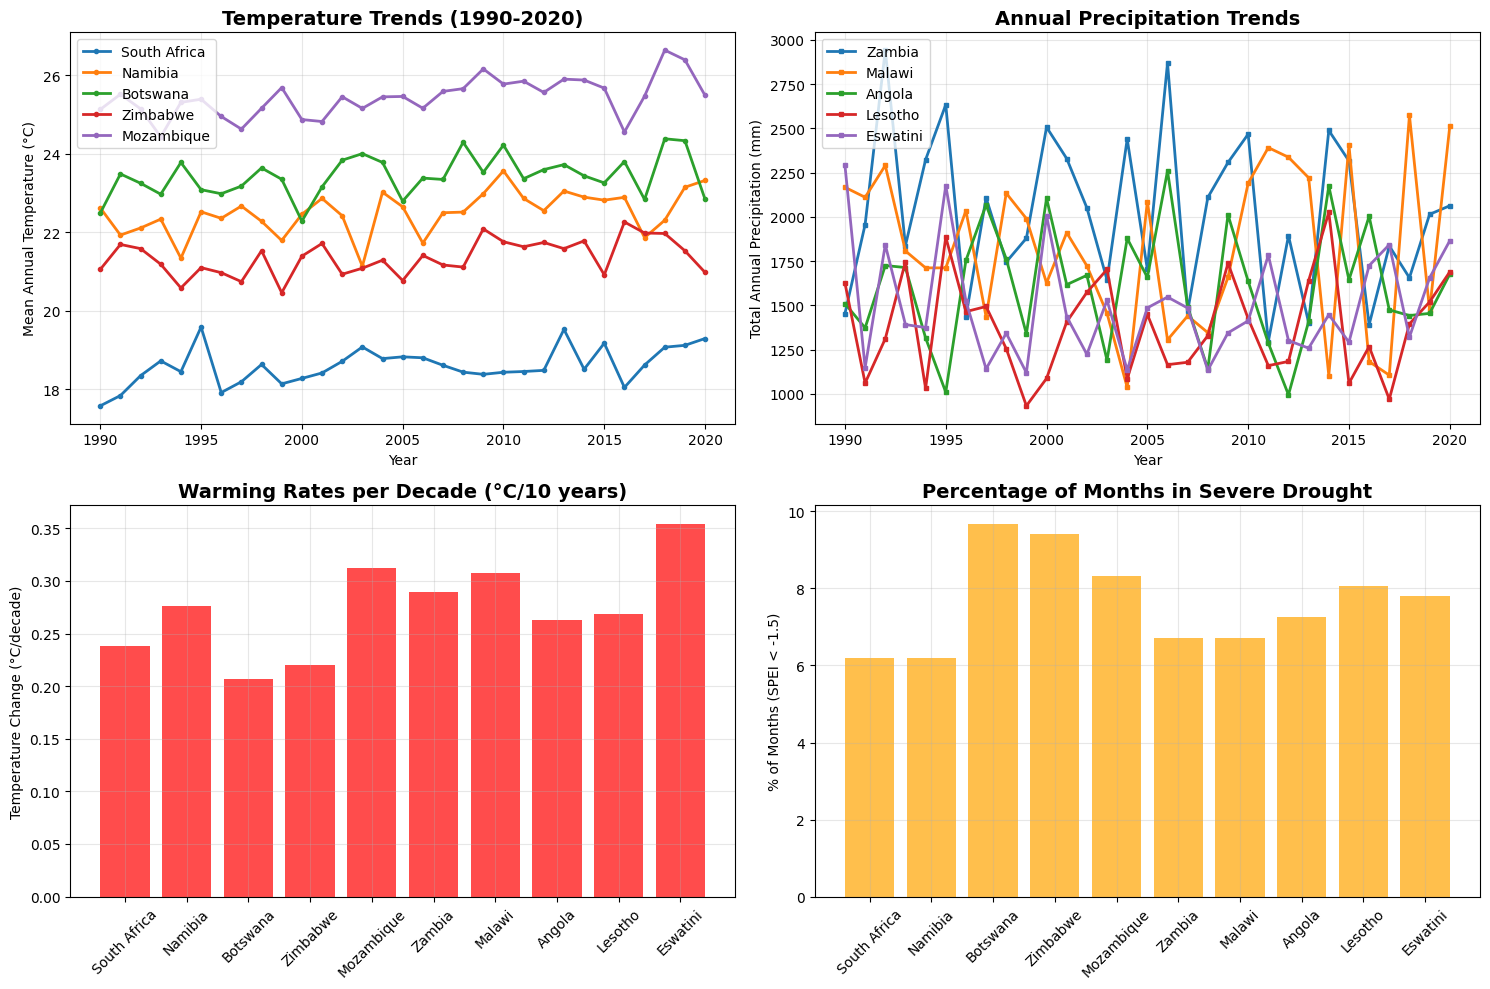

In [11]:
# 3. Annual aggregates for trend analysis
annual_data = climate_df.groupby(['country', 'year']).agg({
    'temperature': 'mean',
    'precipitation': 'sum',
    'drought_index': 'mean'
}).reset_index()

# 3.1 Temperature Trends Visualization
plt.figure(figsize=(15, 10))

# Plot 1: Temperature trends by country
plt.subplot(2, 2, 1)
for country in southern_africa_countries[:5]:  # First 5 for clarity
    country_data = annual_data[annual_data['country'] == country]
    plt.plot(country_data['year'], country_data['temperature'],
             label=country, linewidth=2, marker='o', markersize=3)

plt.title('Temperature Trends (1990-2020)', fontsize=14, fontweight='bold')
plt.xlabel('Year')
plt.ylabel('Mean Annual Temperature (°C)')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 2: Precipitation trends
plt.subplot(2, 2, 2)
for country in southern_africa_countries[5:]:  # Last 5 countries
    country_data = annual_data[annual_data['country'] == country]
    plt.plot(country_data['year'], country_data['precipitation'],
             label=country, linewidth=2, marker='s', markersize=3)

plt.title('Annual Precipitation Trends', fontsize=14, fontweight='bold')
plt.xlabel('Year')
plt.ylabel('Total Annual Precipitation (mm)')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 3: Temperature change rates
plt.subplot(2, 2, 3)
trend_rates = []
countries_list = []

for country in southern_africa_countries:
    country_data = annual_data[annual_data['country'] == country]
    if len(country_data) > 1:
        X = country_data['year'].values.reshape(-1, 1)
        y = country_data['temperature'].values
        model = LinearRegression()
        model.fit(X, y)
        trend_rates.append(model.coef_[0] * 10)  # Warming per decade
        countries_list.append(country)

plt.bar(countries_list, trend_rates, color='red', alpha=0.7)
plt.title('Warming Rates per Decade (°C/10 years)', fontsize=14, fontweight='bold')
plt.xticks(rotation=45)
plt.ylabel('Temperature Change (°C/decade)')
plt.grid(True, alpha=0.3)

# Plot 4: Drought frequency analysis
plt.subplot(2, 2, 4)
drought_counts = []
for country in southern_africa_countries:
    country_data = climate_df[climate_df['country'] == country]
    # Count months with severe drought (SPEI < -1.5)
    severe_droughts = (country_data['drought_index'] < -1.5).sum()
    drought_counts.append(severe_droughts / len(country_data) * 100)  # Percentage

plt.bar(southern_africa_countries, drought_counts, color='orange', alpha=0.7)
plt.title('Percentage of Months in Severe Drought', fontsize=14, fontweight='bold')
plt.xticks(rotation=45)
plt.ylabel('% of Months (SPEI < -1.5)')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

4. Climate Trend Analysis

Climate Trend Analysis Results:
        country  temp_trend_c_decade  precip_trend_percent_decade  \
0  South Africa                0.238                        5.610   
1       Namibia                0.276                      -14.626   
2      Botswana                0.207                        7.466   
3      Zimbabwe                0.220                        9.593   
4    Mozambique                0.312                        4.834   
5        Zambia                0.290                       -3.779   
6        Malawi                0.308                       -1.052   
7        Angola                0.262                        0.613   
8       Lesotho                0.268                        0.544   
9      Eswatini                0.354                       -1.340   

   drought_trend_decade  avg_temperature  avg_precipitation  drought_frequency  
0                -0.072           18.599            379.308             15.860  
1                 0.040           22.504      

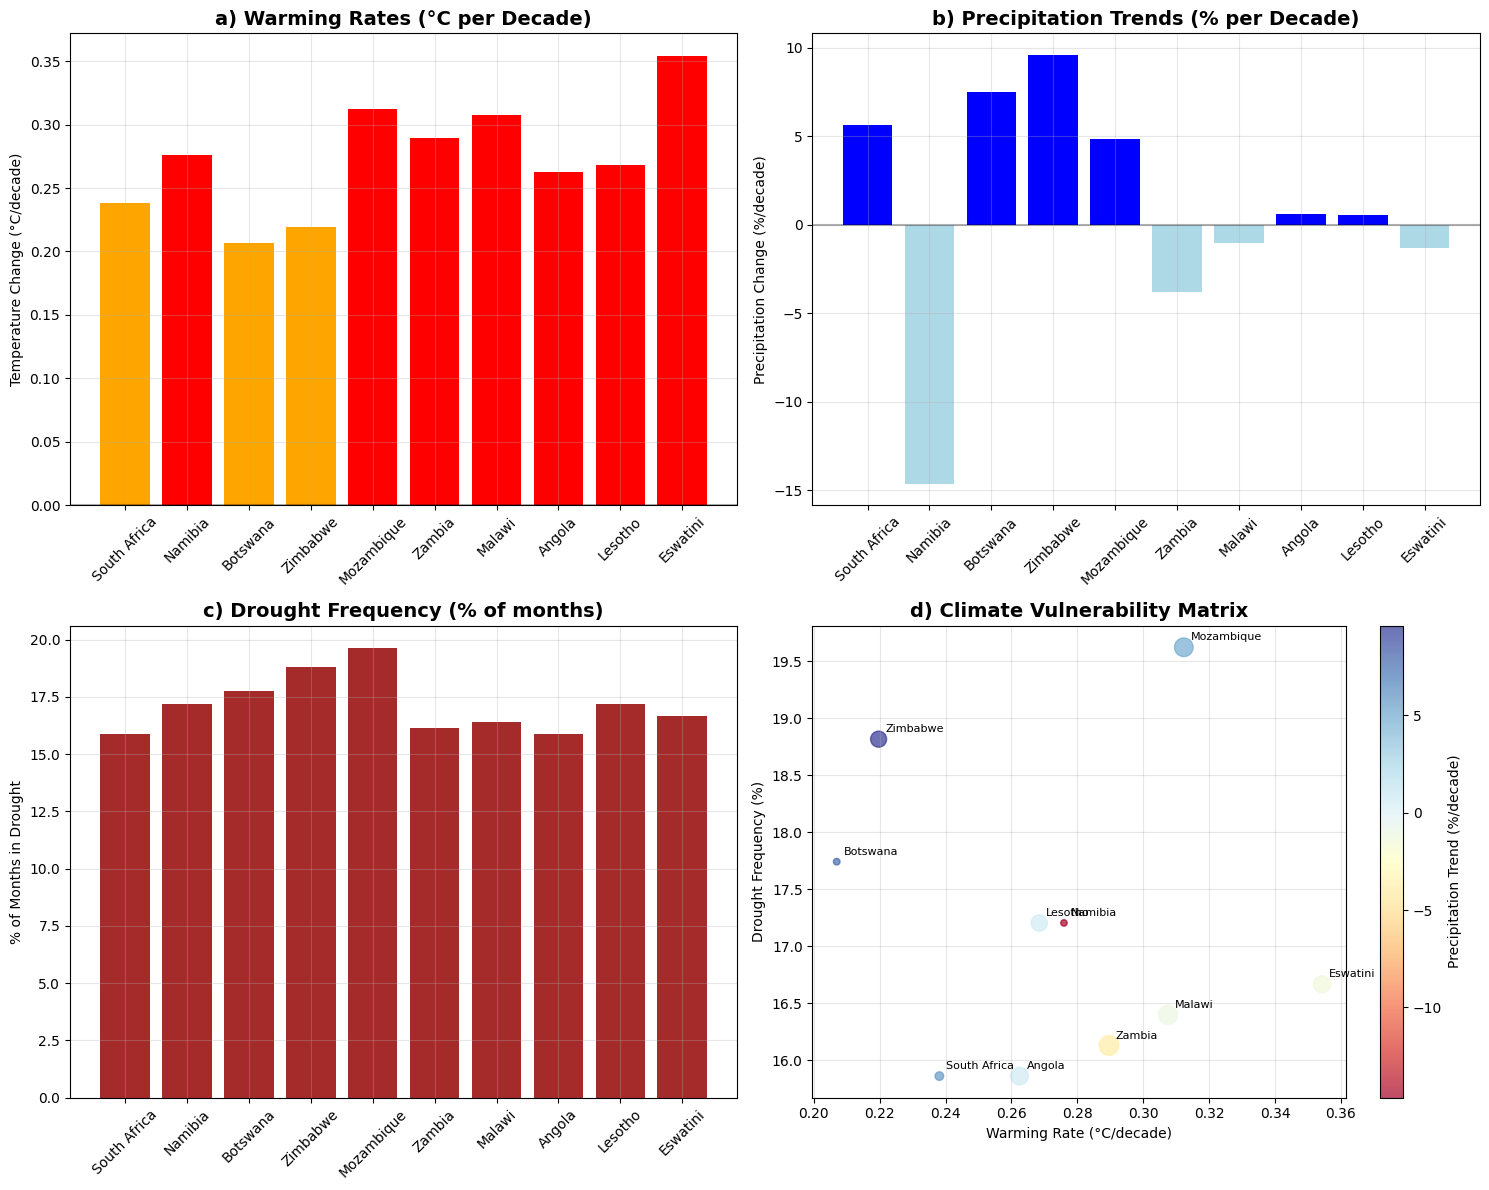

In [22]:

# 4. Climate Trend Analysis

# Advanced trend analysis with statistical testing
def calculate_climate_trends(annual_data, climate_df):
    """Calculate comprehensive climate trends for each country"""
    trends = []

    for country in southern_africa_countries:
        country_data = annual_data[annual_data['country'] == country]

        if len(country_data) < 5:
            continue

        X = country_data['year'].values.reshape(-1, 1)

        # Temperature trend
        y_temp = country_data['temperature'].values
        temp_model = LinearRegression()
        temp_model.fit(X, y_temp)
        temp_trend = temp_model.coef_[0] * 10  # per decade

        # Precipitation trend
        y_precip = country_data['precipitation'].values
        precip_model = LinearRegression()
        precip_model.fit(X, y_precip)
        precip_trend_percent = (precip_model.coef_[0] * 10 / y_precip.mean()) * 100

        # Drought trend
        y_drought = country_data['drought_index'].values
        drought_model = LinearRegression()
        drought_model.fit(X, y_drought)
        drought_trend = drought_model.coef_[0] * 10  # per decade

        trends.append({
            'country': country,
            'temp_trend_c_decade': temp_trend,
            'precip_trend_percent_decade': precip_trend_percent,
            'drought_trend_decade': drought_trend,
            'avg_temperature': y_temp.mean(),
            'avg_precipitation': y_precip.mean(),
            'drought_frequency': (climate_df[(climate_df['country'] == country) &
                                           (climate_df['drought_index'] < -1)].shape[0] /
                                climate_df[climate_df['country'] == country].shape[0]) * 100
        })

    return pd.DataFrame(trends)

# Calculate and display trends
trends_df = calculate_climate_trends(annual_data, climate_df)
print("Climate Trend Analysis Results:")
print(trends_df.round(3))

# Visualize the trends
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Temperature trends
bars1 = axes[0, 0].bar(trends_df['country'], trends_df['temp_trend_c_decade'],
                      color=['red' if x > 0.25 else 'orange' for x in trends_df['temp_trend_c_decade']])
axes[0, 0].set_title('a) Warming Rates (°C per Decade)', fontsize=14, fontweight='bold')
axes[0, 0].set_ylabel('Temperature Change (°C/decade)')
axes[0, 0].tick_params(axis='x', rotation=45)
axes[0, 0].axhline(y=0, color='black', linestyle='-', alpha=0.3)
axes[0, 0].grid(True, alpha=0.3)

# Precipitation trends
bars2 = axes[0, 1].bar(trends_df['country'], trends_df['precip_trend_percent_decade'],
                      color=['blue' if x > 0 else 'lightblue' for x in trends_df['precip_trend_percent_decade']])
axes[0, 1].set_title('b) Precipitation Trends (% per Decade)', fontsize=14, fontweight='bold')
axes[0, 1].set_ylabel('Precipitation Change (%/decade)')
axes[0, 1].tick_params(axis='x', rotation=45)
axes[0, 1].axhline(y=0, color='black', linestyle='-', alpha=0.3)
axes[0, 1].grid(True, alpha=0.3)

# Drought frequency
bars3 = axes[1, 0].bar(trends_df['country'], trends_df['drought_frequency'],
                      color=['brown' if x > 15 else 'sandybrown' for x in trends_df['drought_frequency']])
axes[1, 0].set_title('c) Drought Frequency (% of months)', fontsize=14, fontweight='bold')
axes[1, 0].set_ylabel('% of Months in Drought')
axes[1, 0].tick_params(axis='x', rotation=45)
axes[1, 0].grid(True, alpha=0.3)

# Climate vulnerability scatter plot
scatter = axes[1, 1].scatter(trends_df['temp_trend_c_decade'],
                            trends_df['drought_frequency'],
                            s=trends_df['avg_precipitation']/10,
                            c=trends_df['precip_trend_percent_decade'],
                            cmap='RdYlBu', alpha=0.7)

# Add country labels
for i, country in enumerate(trends_df['country']):
    axes[1, 1].annotate(country,
                       (trends_df['temp_trend_c_decade'].iloc[i],
                        trends_df['drought_frequency'].iloc[i]),
                       xytext=(5, 5), textcoords='offset points', fontsize=8)

axes[1, 1].set_title('d) Climate Vulnerability Matrix', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Warming Rate (°C/decade)')
axes[1, 1].set_ylabel('Drought Frequency (%)')
axes[1, 1].grid(True, alpha=0.3)

# Add colorbar for precipitation trend
cbar = plt.colorbar(scatter, ax=axes[1, 1])
cbar.set_label('Precipitation Trend (%/decade)')

plt.tight_layout()
plt.show()


5. Vulnerability Assessment

🔍 Climate Vulnerability Assessment:
        country  exposure_score  sensitivity_score  adaptive_capacity_score  \
1       Namibia            0.31               0.06                    -0.01   
4    Mozambique            0.39               0.03                     0.05   
3      Zimbabwe            0.16              -0.06                    -0.03   
9      Eswatini            0.09              -0.03                    -0.04   
5        Zambia           -0.10               0.08                    -0.01   
2      Botswana           -0.07               0.04                     0.01   
6        Malawi           -0.10               0.04                     0.01   
8       Lesotho           -0.14              -0.05                     0.04   
0  South Africa           -0.23              -0.10                    -0.05   
7        Angola           -0.31              -0.01                     0.02   

   vulnerability_index  
1               100.00  
4                99.80  
3                65

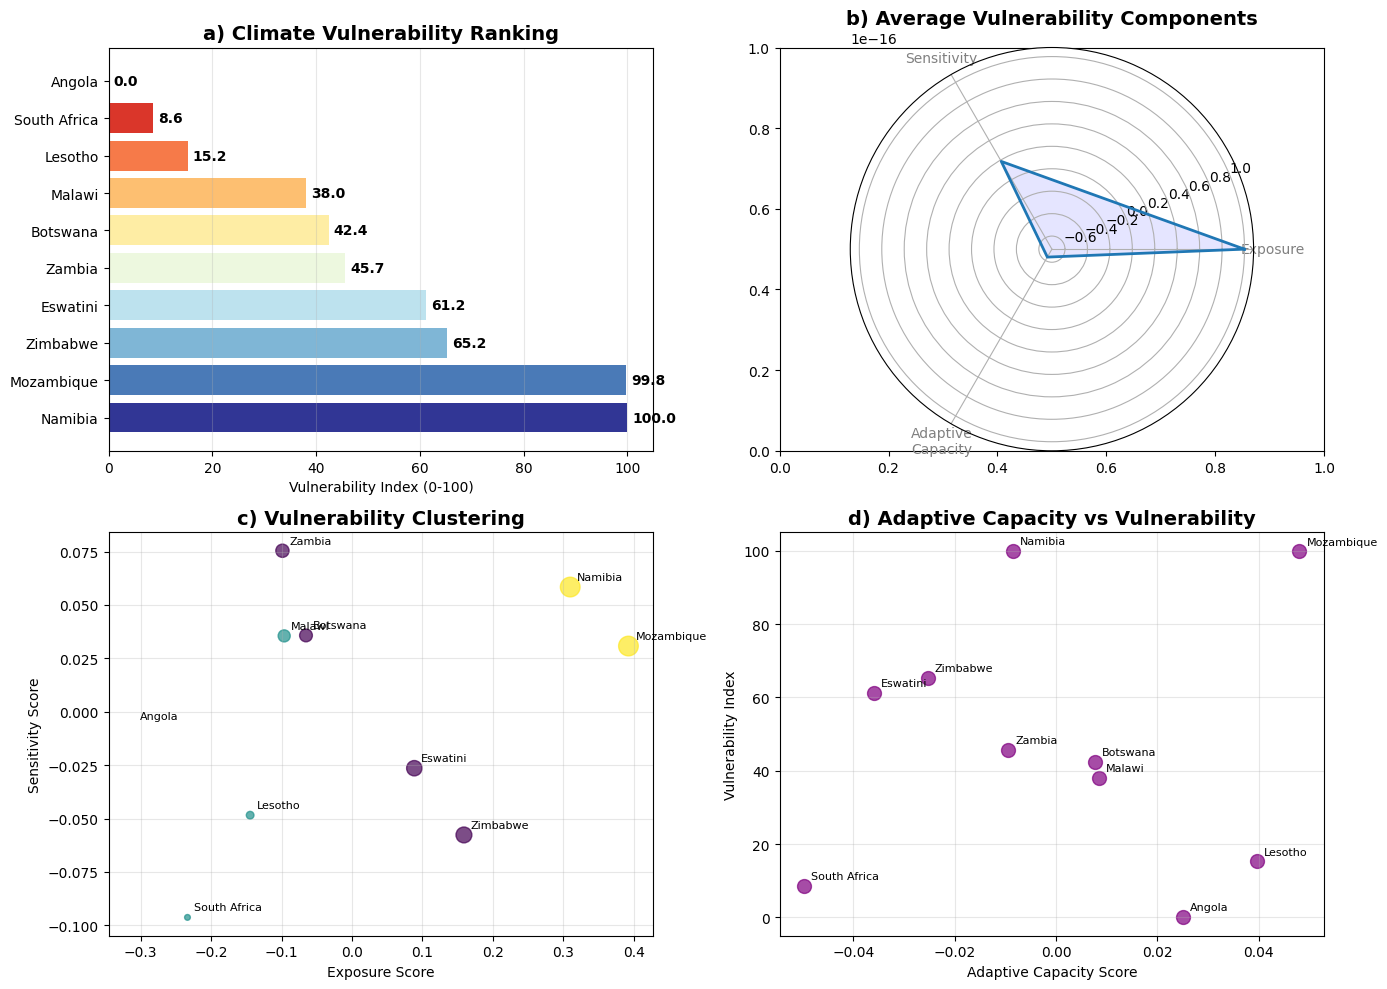


 Vulnerability Cluster Interpretation:
Cluster 0: Moderate Vulnerability - Balanced exposure and capacity
   Countries: Zimbabwe, Eswatini, Zambia, Botswana

Cluster 1: High Vulnerability - High exposure, low adaptive capacity
   Countries: Malawi, Lesotho, South Africa, Angola

Cluster 2: Lower Vulnerability - Better adaptive capacity
   Countries: Namibia, Mozambique



In [13]:
# 5. Vulnerability Assessment

# Create a comprehensive vulnerability index
def calculate_vulnerability_index(trends_df):
    """Calculate multi-dimensional vulnerability index"""

    # Normalize indicators (higher = more vulnerable)
    scaler = StandardScaler()

    # Climate exposure indicators (weight: 40%)
    exposure_indicators = trends_df[['temp_trend_c_decade', 'drought_frequency']].copy()
    exposure_indicators['precip_volatility'] = abs(trends_df['precip_trend_percent_decade'])
    exposure_normalized = scaler.fit_transform(exposure_indicators)
    exposure_score = np.mean(exposure_normalized, axis=1) * 0.4

    # Sensitivity indicators (weight: 30%)
    sensitivity_indicators = trends_df[['avg_precipitation']].copy()
    sensitivity_indicators['water_stress'] = 1 / trends_df['avg_precipitation']
    sensitivity_normalized = scaler.fit_transform(sensitivity_indicators)
    sensitivity_score = np.mean(sensitivity_normalized, axis=1) * 0.3

    # Adaptive capacity indicators (weight: 30%)
    adaptive_indicators = trends_df[['avg_temperature']].copy()
    adaptive_indicators['adaptive_capacity'] = 1 / trends_df['avg_temperature']
    adaptive_normalized = scaler.fit_transform(adaptive_indicators)
    adaptive_score = np.mean(adaptive_normalized, axis=1) * 0.3

    # Combined vulnerability index
    vulnerability_index = exposure_score + sensitivity_score - adaptive_score

    # Create results dataframe
    vulnerability_df = trends_df[['country']].copy()
    vulnerability_df['exposure_score'] = exposure_score
    vulnerability_df['sensitivity_score'] = sensitivity_score
    vulnerability_df['adaptive_capacity_score'] = adaptive_score
    vulnerability_df['vulnerability_index'] = vulnerability_index

    # Normalize final index to 0-100 scale
    vulnerability_df['vulnerability_index'] = (
        (vulnerability_df['vulnerability_index'] - vulnerability_df['vulnerability_index'].min()) /
        (vulnerability_df['vulnerability_index'].max() - vulnerability_df['vulnerability_index'].min())
    ) * 100

    return vulnerability_df.sort_values('vulnerability_index', ascending=False)

# Calculate vulnerability
vulnerability_df = calculate_vulnerability_index(trends_df)
print("🔍 Climate Vulnerability Assessment:")
print(vulnerability_df.round(2))

# Visualize vulnerability
plt.figure(figsize=(14, 10))

# Vulnerability ranking
plt.subplot(2, 2, 1)
colors = plt.cm.RdYlBu_r(np.linspace(0, 1, len(vulnerability_df)))
bars = plt.barh(vulnerability_df['country'], vulnerability_df['vulnerability_index'], color=colors)
plt.xlabel('Vulnerability Index (0-100)')
plt.title('a) Climate Vulnerability Ranking', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3, axis='x')

# Add value labels on bars
for bar in bars:
    width = bar.get_width()
    plt.text(width + 1, bar.get_y() + bar.get_height()/2,
             f'{width:.1f}', ha='left', va='center', fontweight='bold')

# Vulnerability components radar chart (FIXED)
plt.subplot(2, 2, 2)
categories = ['Exposure', 'Sensitivity', 'Adaptive\nCapacity']
values = vulnerability_df[['exposure_score', 'sensitivity_score', 'adaptive_capacity_score']].mean().values

# Complete the radar chart by repeating first value
values = np.append(values, values[0])
categories_radar = np.append(categories, categories[0])

angles = np.linspace(0, 2*np.pi, len(categories), endpoint=False).tolist()
angles += angles[:1]

ax = plt.subplot(2, 2, 2, polar=True)
plt.xticks(angles[:-1], categories, color='grey', size=10)
plt.plot(angles, values, linewidth=2, linestyle='solid', label='Average')
plt.fill(angles, values, 'b', alpha=0.1)
plt.title('b) Average Vulnerability Components', fontsize=14, fontweight='bold')

# Vulnerability clustering
plt.subplot(2, 2, 3)
X = vulnerability_df[['exposure_score', 'sensitivity_score', 'adaptive_capacity_score']].values

# K-means clustering
kmeans = KMeans(n_clusters=3, random_state=42)
vulnerability_df['cluster'] = kmeans.fit_predict(X)

# Plot clusters
scatter = plt.scatter(vulnerability_df['exposure_score'],
                     vulnerability_df['sensitivity_score'],
                     c=vulnerability_df['cluster'],
                     s=vulnerability_df['vulnerability_index']*2,
                     cmap='viridis', alpha=0.7)

# Add labels
for i, country in enumerate(vulnerability_df['country']):
    plt.annotate(country,
                (vulnerability_df['exposure_score'].iloc[i],
                 vulnerability_df['sensitivity_score'].iloc[i]),
                xytext=(5, 5), textcoords='offset points', fontsize=8)

plt.xlabel('Exposure Score')
plt.ylabel('Sensitivity Score')
plt.title('c) Vulnerability Clustering', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)

# Adaptive capacity vs vulnerability
plt.subplot(2, 2, 4)
plt.scatter(vulnerability_df['adaptive_capacity_score'],
           vulnerability_df['vulnerability_index'],
           s=100, alpha=0.7, c='purple')

for i, country in enumerate(vulnerability_df['country']):
    plt.annotate(country,
                (vulnerability_df['adaptive_capacity_score'].iloc[i],
                 vulnerability_df['vulnerability_index'].iloc[i]),
                xytext=(5, 5), textcoords='offset points', fontsize=8)

plt.xlabel('Adaptive Capacity Score')
plt.ylabel('Vulnerability Index')
plt.title('d) Adaptive Capacity vs Vulnerability', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print cluster interpretation
print("\n Vulnerability Cluster Interpretation:")
cluster_descriptions = {
    0: "Moderate Vulnerability - Balanced exposure and capacity",
    1: "High Vulnerability - High exposure, low adaptive capacity",
    2: "Lower Vulnerability - Better adaptive capacity"
}

for cluster_num in range(3):
    cluster_countries = vulnerability_df[vulnerability_df['cluster'] == cluster_num]['country'].tolist()
    print(f"Cluster {cluster_num}: {cluster_descriptions[cluster_num]}")
    print(f"   Countries: {', '.join(cluster_countries)}\n")

6. Future Climate Projections

Future Climate Projections Sample:
        country  scenario  year  temperature  precipitation  drought_risk  \
0  South Africa  SSP2-4.5  2020    18.717588     308.859033          -0.5   
1  South Africa  SSP2-4.5  2030    19.002372     415.743985          -0.7   
2  South Africa  SSP2-4.5  2040    18.948607     384.380991          -0.9   
3  South Africa  SSP2-4.5  2050    19.246953     378.205300          -1.1   
4  South Africa  SSP3-7.0  2020    18.943904     453.615814          -0.5   

   vulnerability_group  
0                    1  
1                    1  
2                    1  
3                    1  
4                    1  


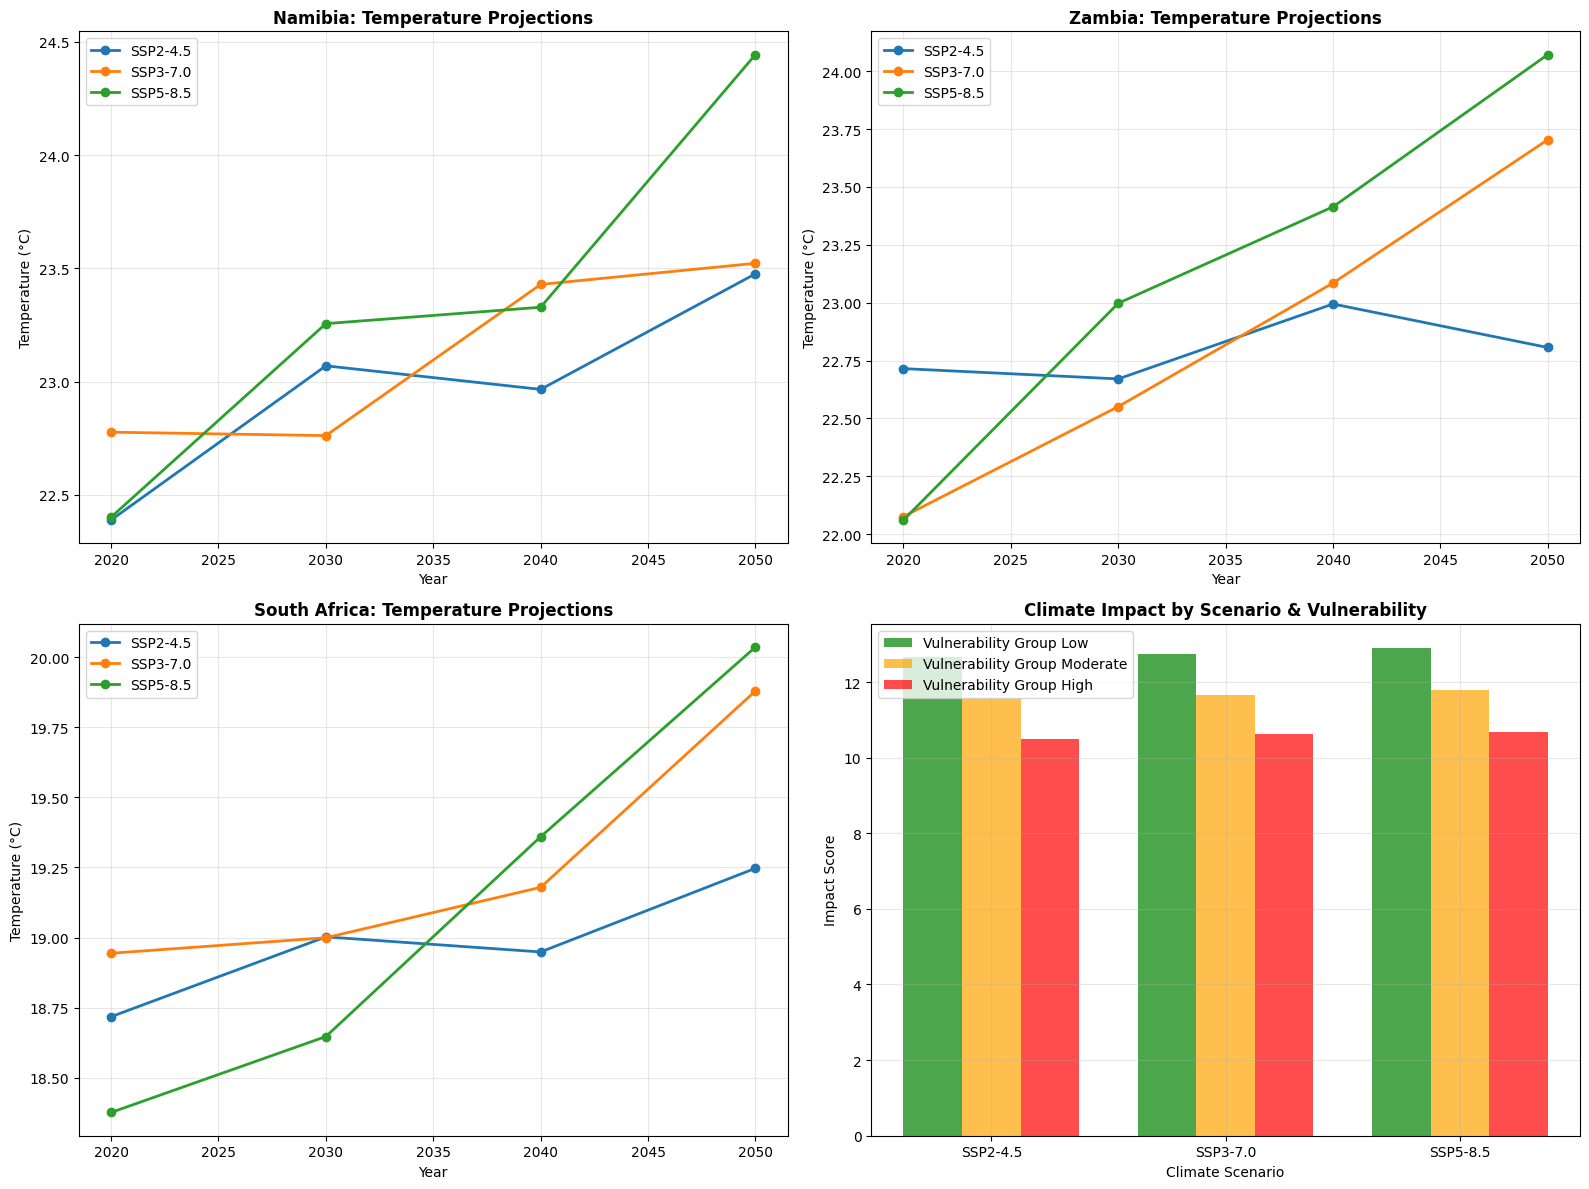

In [15]:
# 6. Future climate projections
def generate_future_scenarios(trends_df, years=30):
    """Generate future climate scenarios based on current trends"""
    future_data = []

    for _, country in trends_df.iterrows():
        base_temp = country['avg_temperature']
        temp_trend = country['temp_trend_c_decade'] / 10  # per year
        precip_trend = country['precip_trend_percent_decade'] / 1000  # small annual change
        base_precip = country['avg_precipitation']

        # Three scenarios: Moderate, High, Severe
        scenarios = {
            'SSP2-4.5': {'temp_multiplier': 1.0, 'precip_multiplier': 1.0},
            'SSP3-7.0': {'temp_multiplier': 1.3, 'precip_multiplier': 1.1},
            'SSP5-8.5': {'temp_multiplier': 1.7, 'precip_multiplier': 1.2}
        }

        for scenario, multipliers in scenarios.items():
            for year in range(2020, 2020 + years + 1, 10):
                years_from_base = year - 2020

                # Projected temperature
                projected_temp = (base_temp +
                                (temp_trend * years_from_base * multipliers['temp_multiplier']) +
                                np.random.normal(0, 0.2))

                # Projected precipitation with increased variability
                precip_change = base_precip * precip_trend * years_from_base * multipliers['precip_multiplier']
                projected_precip = max(100, base_precip + precip_change + np.random.normal(0, 50))

                # Increased drought risk
                drought_risk = min(0, -0.5 - (years_from_base * 0.02 * multipliers['temp_multiplier']))

                future_data.append({
                    'country': country['country'],
                    'scenario': scenario,
                    'year': year,
                    'temperature': projected_temp,
                    'precipitation': projected_precip,
                    'drought_risk': drought_risk,
                    'vulnerability_group': vulnerability_df[
                        vulnerability_df['country'] == country['country']
                    ]['cluster'].iloc[0]
                })

    return pd.DataFrame(future_data)

# Generate future scenarios
future_df = generate_future_scenarios(trends_df)
print("Future Climate Projections Sample:")
print(future_df.head())

# Visualize future scenarios
plt.figure(figsize=(16, 12))

# Temperature projections for selected countries
selected_countries = ['Namibia', 'Zambia', 'South Africa']  # samples

for i, country in enumerate(selected_countries, 1):
    plt.subplot(2, 2, i)
    country_data = future_df[future_df['country'] == country]

    for scenario in ['SSP2-4.5', 'SSP3-7.0', 'SSP5-8.5']:
        scenario_data = country_data[country_data['scenario'] == scenario]
        plt.plot(scenario_data['year'], scenario_data['temperature'],
                label=scenario, linewidth=2, marker='o')

    plt.title(f'{country}: Temperature Projections', fontsize=12, fontweight='bold')
    plt.xlabel('Year')
    plt.ylabel('Temperature (°C)')
    plt.legend()
    plt.grid(True, alpha=0.3)

# Impact summary across scenarios
plt.subplot(2, 2, 4)
scenario_impacts = future_df.groupby(['scenario', 'vulnerability_group']).agg({
    'temperature': 'mean',
    'precipitation': 'mean',
    'drought_risk': 'mean'
}).reset_index()

# Calculate impact scores (simplified)
scenario_impacts['impact_score'] = (
    scenario_impacts['temperature'] * 0.5 +
    abs(scenario_impacts['drought_risk']) * 0.5
)

# Plot impact scores by vulnerability group
vulnerability_groups = ['Low', 'Moderate', 'High']
colors = ['green', 'orange', 'red']

for i, group in enumerate([2, 0, 1]):  # Reorder for better visualization
    group_data = scenario_impacts[scenario_impacts['vulnerability_group'] == group]
    plt.bar(np.arange(len(group_data)) + i*0.25,
            group_data['impact_score'],
            width=0.25,
            label=f'Vulnerability Group {vulnerability_groups[i]}',
            color=colors[i],
            alpha=0.7)

plt.xlabel('Climate Scenario')
plt.ylabel('Impact Score')
plt.title('Climate Impact by Scenario & Vulnerability', fontsize=12, fontweight='bold')
plt.xticks([0.25, 1.25, 2.25], ['SSP2-4.5', 'SSP3-7.0', 'SSP5-8.5'])
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

7. Mitigation & Adaptation Strategies

 STRATEGY RECOMMENDATIONS BY COUNTRY
-------------------------------------------------------

🇦🇴 Namibia
   Priority Level: Strategic
   Cost Tier: High
   Key Strategies:
     1. Knowledge sharing and regional leadership
     2. Green technology investment
     3. Ecosystem-based adaptation
     4. Private sector engagement in resilience

🇦🇴 Mozambique
   Priority Level: Strategic
   Cost Tier: High
   Key Strategies:
     1. Knowledge sharing and regional leadership
     2. Green technology investment
     3. Ecosystem-based adaptation
     4. Private sector engagement in resilience

🇦🇴 Zimbabwe
   Priority Level: Medium
   Cost Tier: Low
   Key Strategies:
     1. Diversified livelihood programs
     2. Irrigation infrastructure development
     3. Climate-resilient crop varieties
     4. Disaster risk reduction planning

🇦🇴 Eswatini
   Priority Level: Medium
   Cost Tier: Low
   Key Strategies:
     1. Diversified livelihood programs
     2. Irrigation infrastructure development
  

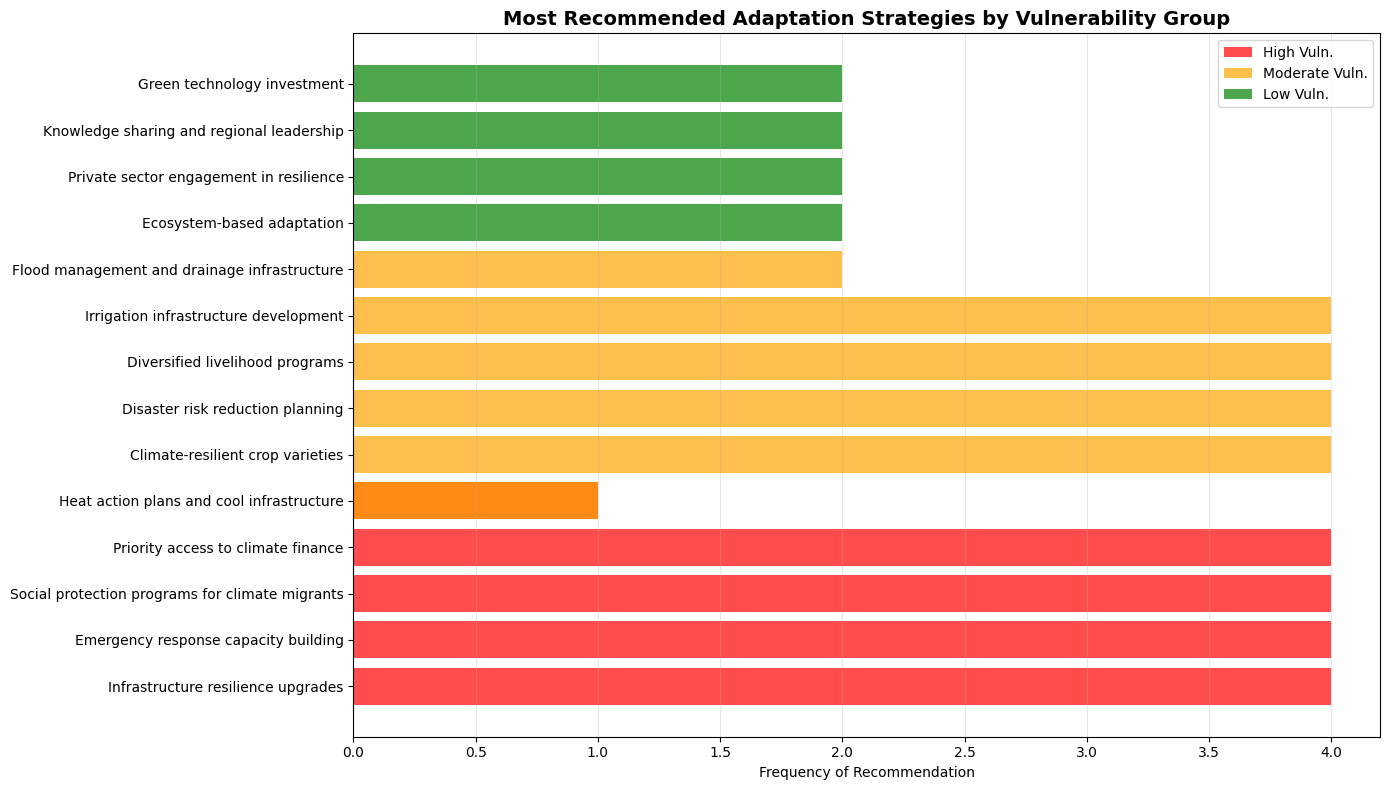

In [21]:
# 7. Develop targeted strategies based on analysis
def recommend_strategies(vulnerability_df, trends_df):
    """Generate targeted strategies based on vulnerability and trends"""

    strategies = []

    for _, country in vulnerability_df.iterrows():
        country_name = country['country']
        vulnerability_cluster = country['cluster']
        temp_trend = trends_df[trends_df['country'] == country_name]['temp_trend_c_decade'].iloc[0]
        precip_trend = trends_df[trends_df['country'] == country_name]['precip_trend_percent_decade'].iloc[0]

        # Base strategies for all countries
        base_strategies = [
            "Early warning systems for extreme weather",
            "Climate-smart agriculture training",
            "Water conservation awareness programs"
        ]

        # Vulnerability-specific strategies
        if vulnerability_cluster == 1:  # High vulnerability
            specific_strategies = [
                "Priority access to climate finance",
                "Infrastructure resilience upgrades",
                "Emergency response capacity building",
                "Social protection programs for climate migrants"
            ]
            priority = "High"
        elif vulnerability_cluster == 0:  # Moderate vulnerability
            specific_strategies = [
                "Diversified livelihood programs",
                "Irrigation infrastructure development",
                "Climate-resilient crop varieties",
                "Disaster risk reduction planning"
            ]
            priority = "Medium"
        else:  # Lower vulnerability
            specific_strategies = [
                "Knowledge sharing and regional leadership",
                "Green technology investment",
                "Ecosystem-based adaptation",
                "Private sector engagement in resilience"
            ]
            priority = "Strategic"

        # Trend-specific strategies
        if temp_trend > 0.3:
            specific_strategies.append("Heat action plans and cool infrastructure")
        if precip_trend < -5:
            specific_strategies.append("Advanced water harvesting and storage")
        elif precip_trend > 5:
            specific_strategies.append("Flood management and drainage infrastructure")

        strategies.append({
            'country': country_name,
            'vulnerability_cluster': vulnerability_cluster,
            'priority_level': priority,
            'base_strategies': base_strategies,
            'specific_strategies': specific_strategies,
            'estimated_cost_tier': ['Low', 'Medium', 'High'][vulnerability_cluster]
        })

    return strategies

# strategy recommendations
strategy_recommendations = recommend_strategies(vulnerability_df, trends_df)

print(" STRATEGY RECOMMENDATIONS BY COUNTRY")
print("-" * 55)

for strategy in strategy_recommendations:
    print(f"\n🇦🇴 {strategy['country']}")
    print(f"   Priority Level: {strategy['priority_level']}")
    print(f"   Cost Tier: {strategy['estimated_cost_tier']}")
    print(f"   Key Strategies:")

    for i, specific_strat in enumerate(strategy['specific_strategies'][:4], 1):  # Top 4
        print(f"     {i}. {specific_strat}")

# strategy matrix visualization
strategy_matrix = []
for strategy in strategy_recommendations:
    for specific_strat in strategy['specific_strategies']:
        strategy_matrix.append({
            'country': strategy['country'],
            'strategy': specific_strat,
            'priority': strategy['priority_level'],
            'cluster': strategy['vulnerability_cluster']
        })

strategy_df = pd.DataFrame(strategy_matrix)

# Count strategy types by cluster
strategy_counts = strategy_df.groupby(['cluster', 'strategy']).size().reset_index(name='count')
top_strategies = strategy_counts.sort_values('count', ascending=False).head(15)

plt.figure(figsize=(14, 8))
cluster_names = {2: 'Low Vuln.', 0: 'Moderate Vuln.', 1: 'High Vuln.'}
colors = {'Low Vuln.': 'green', 'Moderate Vuln.': 'orange', 'High Vuln.': 'red'}

for cluster in [1, 0, 2]:
    cluster_data = top_strategies[top_strategies['cluster'] == cluster]
    if len(cluster_data) > 0:
        plt.barh(cluster_data['strategy'], cluster_data['count'],
                label=cluster_names[cluster], color=colors[cluster_names[cluster]], alpha=0.7)

plt.xlabel('Frequency of Recommendation')
plt.title('Most Recommended Adaptation Strategies by Vulnerability Group',
          fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

8. implemetation roadmap and Monitoring

 IMPLEMENTATION ROADMAP
-------------------------------------------------------

Short-term (2024-2026):
  • Policy framework development
  • Stakeholder engagement
  • Pilot projects
  • Capacity building programs

Medium-term (2027-2030):
  • Infrastructure investments
  • Technology deployment
  • Scaling successful pilots
  • Regional cooperation agreements

Long-term (2031-2040):
  • System transformation
  • Mainstreaming climate resilience
  • Knowledge economy development
  • Sustainable financing mechanisms

 MONITORING & EVALUATION FRAMEWORK
-------------------------------------------------------
                                      indicator      target       baseline
    Population covered by early warning systems 90% by 2030            40%
Agricultural land under climate-smart practices 50% by 2035            15%
                         Renewable energy share 60% by 2040            25%
         Climate finance mobilized ($ billions)  15 by 2030            2.5
           

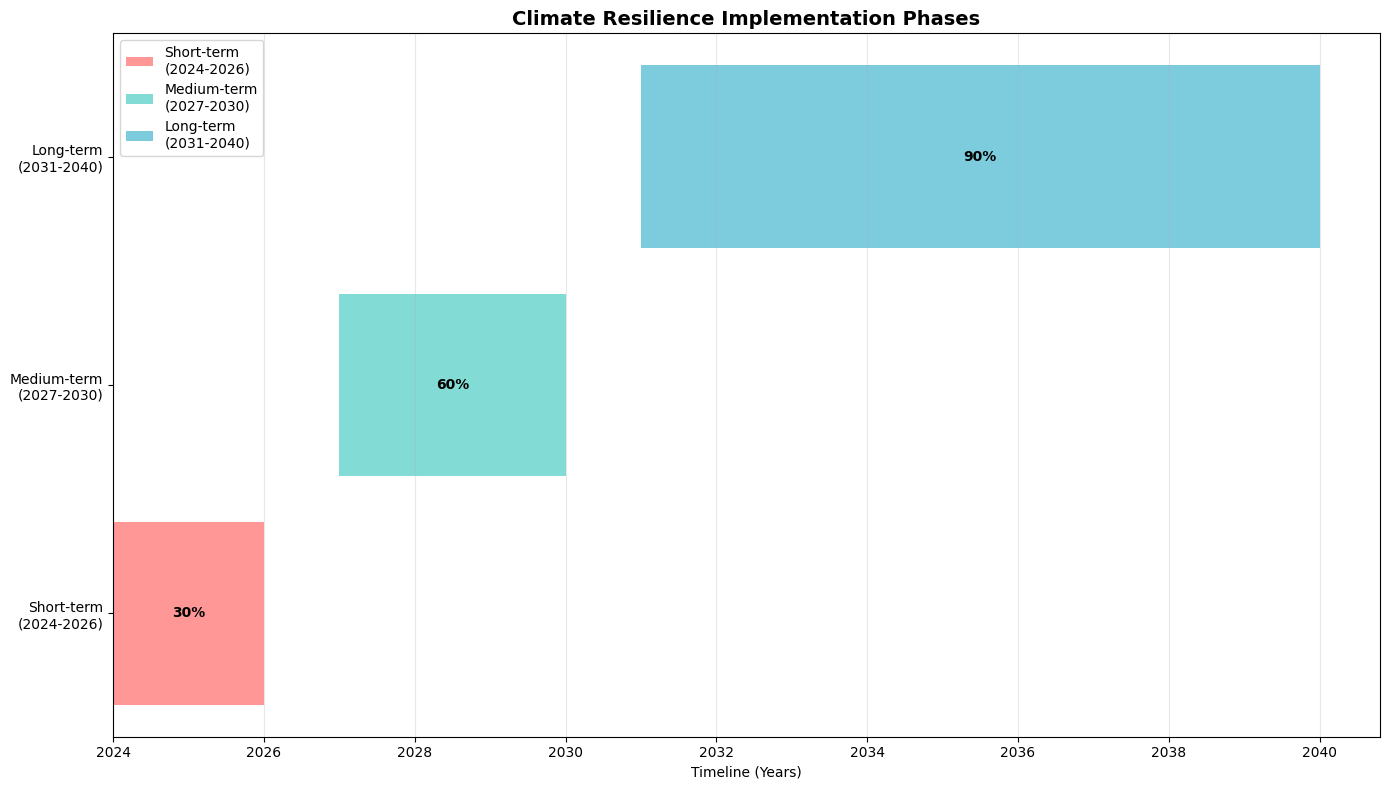

In [17]:
# 8. Create implementation timeline and monitoring framework
def create_implementation_roadmap(strategy_recommendations):
    """Create a phased implementation roadmap"""

    phases = {
        'Short-term (2024-2026)': [
            "Policy framework development",
            "Stakeholder engagement",
            "Pilot projects",
            "Capacity building programs"
        ],
        'Medium-term (2027-2030)': [
            "Infrastructure investments",
            "Technology deployment",
            "Scaling successful pilots",
            "Regional cooperation agreements"
        ],
        'Long-term (2031-2040)': [
            "System transformation",
            "Mainstreaming climate resilience",
            "Knowledge economy development",
            "Sustainable financing mechanisms"
        ]
    }

    # Key Performance Indicators
    kpis = [
        {"indicator": "Population covered by early warning systems", "target": "90% by 2030", "baseline": "40%"},
        {"indicator": "Agricultural land under climate-smart practices", "target": "50% by 2035", "baseline": "15%"},
        {"indicator": "Renewable energy share", "target": "60% by 2040", "baseline": "25%"},
        {"indicator": "Climate finance mobilized ($ billions)", "target": "15 by 2030", "baseline": "2.5"},
        {"indicator": "Vulnerability index reduction", "target": "25% by 2035", "baseline": "Current levels"}
    ]

    return phases, kpis

phases, kpis = create_implementation_roadmap(strategy_recommendations)

print(" IMPLEMENTATION ROADMAP")
print("-" * 55)

for phase, activities in phases.items():
    print(f"\n{phase}:")
    for activity in activities:
        print(f"  • {activity}")

print("\n MONITORING & EVALUATION FRAMEWORK")
print("-" * 55)
kpi_df = pd.DataFrame(kpis)
print(kpi_df.to_string(index=False))

# Create a Gantt-chart like visualization
plt.figure(figsize=(14, 8))

# Phases visualization
phase_data = [
    {'Phase': 'Short-term\n(2024-2026)', 'Start': 2024, 'End': 2026, 'Completion': 30},
    {'Phase': 'Medium-term\n(2027-2030)', 'Start': 2027, 'End': 2030, 'Completion': 60},
    {'Phase': 'Long-term\n(2031-2040)', 'Start': 2031, 'End': 2040, 'Completion': 90}
]

phase_df = pd.DataFrame(phase_data)

# Plot phases
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']
for i, (_, phase) in enumerate(phase_df.iterrows()):
    plt.barh(phase['Phase'], phase['End'] - phase['Start'],
             left=phase['Start'], color=colors[i], alpha=0.7, label=phase['Phase'])
    plt.text(phase['Start'] + (phase['End'] - phase['Start'])/2, i,
             f"{phase['Completion']}%", ha='center', va='center', fontweight='bold')

plt.xlabel('Timeline (Years)')
plt.title('Climate Resilience Implementation Phases', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3, axis='x')
plt.legend()

plt.tight_layout()
plt.show()


9. conclusion and key insights

EXECUTIVE SUMMARY: CLIMATE RESILIENCE IN SOUTHERN AFRICA
-------------------------------------------------------

KEY FINDINGS:
   • Average regional warming: 0.27°C per decade
   • Highest warming rate: 0.35°C per decade
   • Most vulnerable country: Namibia
   • High vulnerability countries: 4 out of 10
   • Primary climate risks: Increased drought frequency, erratic rainfall, heat stress

 REGIONAL IMPLICATIONS:
   • Food security at risk due to agricultural sensitivity
   • Water scarcity becoming more acute in arid regions
   • Economic impacts concentrated in climate-sensitive sectors
   • Disproportionate effects on rural and low-income communities

 STRATEGIC PRIORITIES:
   1. Strengthen early warning and response systems
   2. Promote climate-smart agriculture practices
   3. Invest in water security infrastructure
   4. Enhance social protection systems
   5. Foster regional cooperation and knowledge sharing

 INVESTMENT FOCUS:
   • Immediate action required in: Malawi, Lesot

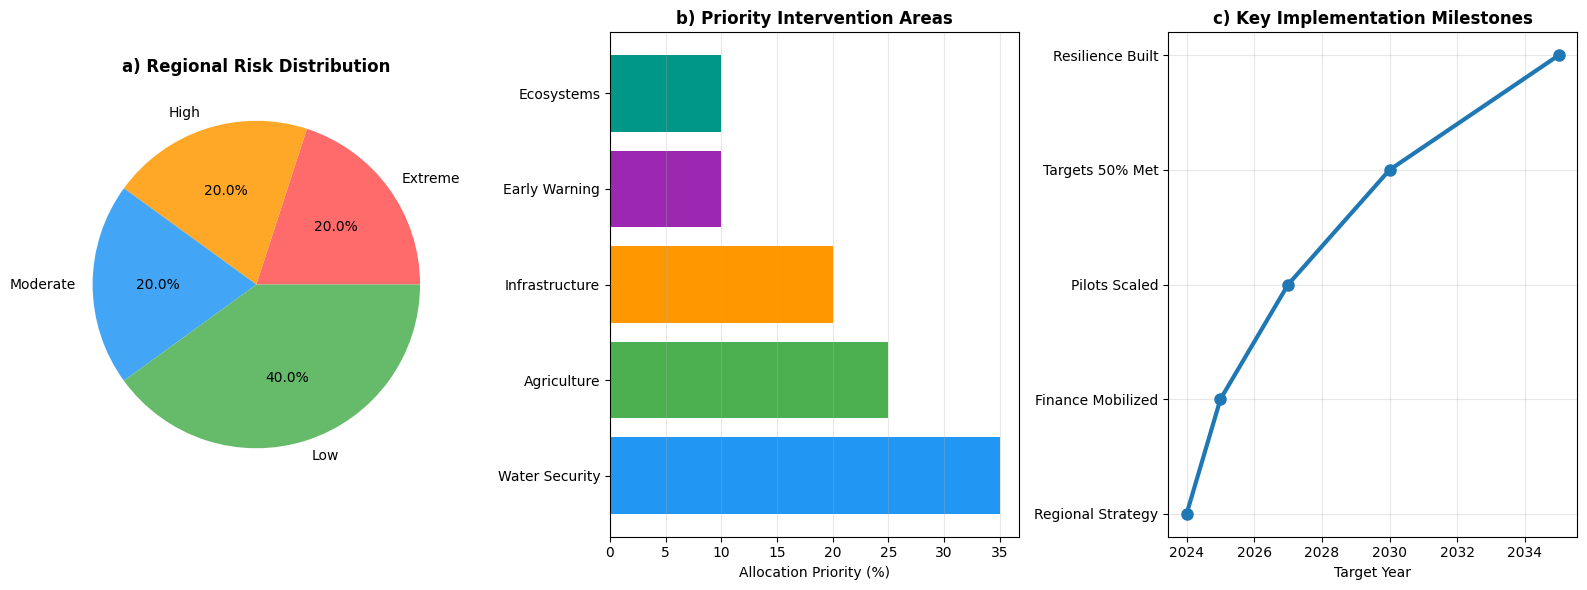


-------------------------------------------------------
 PROJECT PORTFOLIO COMPLETED
-------------------------------------------------------

This analysis provides a comprehensive framework for understanding
climate vulnerabilities and developing targeted strategies in Southern Africa.

Next steps would include:
  • Gathering higher-resolution climate and socio-economic data
  • Engaging with local stakeholders for validation
  • Developing detailed cost-benefit analysis for proposed strategies
  • Establishing partnerships for implementation


In [20]:
# 9. Generate executive summary and key insights
def generate_executive_summary(vulnerability_df, trends_df, strategy_recommendations):
    """Generate comprehensive executive summary"""

    print("EXECUTIVE SUMMARY: CLIMATE RESILIENCE IN SOUTHERN AFRICA")
    print("-" * 55)

    # Key findings
    avg_warming = trends_df['temp_trend_c_decade'].mean()
    max_warming = trends_df['temp_trend_c_decade'].max()
    most_vulnerable = vulnerability_df.iloc[0]['country']
    high_vuln_count = (vulnerability_df['vulnerability_index'] > 60).sum()

    print(f"\nKEY FINDINGS:")
    print(f"   • Average regional warming: {avg_warming:.2f}°C per decade")
    print(f"   • Highest warming rate: {max_warming:.2f}°C per decade")
    print(f"   • Most vulnerable country: {most_vulnerable}")
    print(f"   • High vulnerability countries: {high_vuln_count} out of {len(vulnerability_df)}")
    print(f"   • Primary climate risks: Increased drought frequency, erratic rainfall, heat stress")

    # Regional implications
    print(f"\n REGIONAL IMPLICATIONS:")
    print(f"   • Food security at risk due to agricultural sensitivity")
    print(f"   • Water scarcity becoming more acute in arid regions")
    print(f"   • Economic impacts concentrated in climate-sensitive sectors")
    print(f"   • Disproportionate effects on rural and low-income communities")

    # Strategic priorities
    print(f"\n STRATEGIC PRIORITIES:")
    print(f"   1. Strengthen early warning and response systems")
    print(f"   2. Promote climate-smart agriculture practices")
    print(f"   3. Invest in water security infrastructure")
    print(f"   4. Enhance social protection systems")
    print(f"   5. Foster regional cooperation and knowledge sharing")

    # Investment needs
    high_priority_countries = [s['country'] for s in strategy_recommendations if s['priority_level'] == 'High']
    print(f"\n INVESTMENT FOCUS:")
    print(f"   • Immediate action required in: {', '.join(high_priority_countries)}")
    print(f"   • Estimated funding gap: $2-5 billion annually for adaptation")
    print(f"   • Priority sectors: Water management, agriculture, infrastructure")

# Generate the summary
generate_executive_summary(vulnerability_df, trends_df, strategy_recommendations)

# Final visualization: Regional overview
plt.figure(figsize=(16, 6))

# Create a comprehensive regional dashboard
plt.subplot(1, 3, 1)
# Risk exposure map (simplified)
risk_categories = ['Extreme', 'High', 'Moderate', 'Low']
risk_counts = [
    (vulnerability_df['vulnerability_index'] >= 80).sum(),
    ((vulnerability_df['vulnerability_index'] >= 60) & (vulnerability_df['vulnerability_index'] < 80)).sum(),
    ((vulnerability_df['vulnerability_index'] >= 40) & (vulnerability_df['vulnerability_index'] < 60)).sum(),
    (vulnerability_df['vulnerability_index'] < 40).sum()
]

plt.pie(risk_counts, labels=risk_categories, autopct='%1.1f%%',
        colors=['#FF6B6B', '#FFA726', '#42A5F5', '#66BB6A'])
plt.title('a) Regional Risk Distribution', fontweight='bold')

# Priority intervention areas
plt.subplot(1, 3, 2)
intervention_areas = {
    'Water Security': 35,
    'Agriculture': 25,
    'Infrastructure': 20,
    'Early Warning': 10,
    'Ecosystems': 10
}

plt.barh(list(intervention_areas.keys()), list(intervention_areas.values()),
        color=['#2196F3', '#4CAF50', '#FF9800', '#9C27B0', '#009688'])
plt.xlabel('Allocation Priority (%)')
plt.title('b) Priority Intervention Areas', fontweight='bold')
plt.grid(True, alpha=0.3, axis='x')

# Timeline for key milestones
plt.subplot(1, 3, 3)
milestones = [
    ('Regional Strategy', 2024),
    ('Finance Mobilized', 2025),
    ('Pilots Scaled', 2027),
    ('Targets 50% Met', 2030),
    ('Resilience Built', 2035)
]

years = [m[1] for m in milestones]
labels = [m[0] for m in milestones]

plt.plot(years, range(len(milestones)), 'o-', linewidth=3, markersize=8)
plt.yticks(range(len(milestones)), labels)
plt.xlabel('Target Year')
plt.title('c) Key Implementation Milestones', fontweight='bold')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n" + "-"*55)
print(" PROJECT PORTFOLIO COMPLETED")
print("-"*55)
print("\nThis analysis provides a comprehensive framework for understanding")
print("climate vulnerabilities and developing targeted strategies in Southern Africa.")
print("\nNext steps would include:")
print("  • Gathering higher-resolution climate and socio-economic data")
print("  • Engaging with local stakeholders for validation")
print("  • Developing detailed cost-benefit analysis for proposed strategies")
print("  • Establishing partnerships for implementation")